### 0.import library and set configration

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm
# グラフをインラインで表示させる
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語化matplotlib
%matplotlib inline

import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

#from ydata_profiling import ProfileReport
import pickle


import warnings
# 全ての警告を無視する
warnings.filterwarnings("ignore")

In [2]:
#機械学習用のライブラリインストール
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import lightgbm as lgb
import optuna
import shap
from imblearn.under_sampling import RandomUnderSampler


In [3]:
import geopandas as gpd


In [4]:
#import_original_function
from function.data_processing import test2
from function.data_processing import addtional_process
from function.modeling import objective

In [5]:
#pandasの表示設定
# 表示制限の緩和
pd.set_option('display.max_columns', 300 )
pd.set_option('display.max_rows', 500 )
# 指数表記の無効化
pd.options.display.float_format = '{:.2f}'.format

In [6]:
#configファイルの読み込み
import configparser
config_ini = configparser.ConfigParser()
config_ini.read('./config/config.ini', encoding='utf-8')

['./config/config.ini']

In [7]:
#read_file_congfig
test_file                = config_ini["INPUT_FILE"]["test_edited"]
train_file               = config_ini["INPUT_FILE"]["train_edited"]
deginition_file          = config_ini["CONFIG_FILE"]["deginition"]
submit_file              = config_ini["OUTPUT_FILE"]["submit"]
    
shap_plot_file           = config_ini["OUTPUT_FILE"]["shap_plot"]
predict_result_plot_file = config_ini["OUTPUT_FILE"]["predict_result_plot"]

model_file               = config_ini["OUTPUT_FILE"]["model"]
dbscan_model_file        = config_ini["OUTPUT_FILE"]["dbscan_model"]

#read_var_config
response_var             = config_ini["VAR"]["response_var"]


### 1.import_train/test_data


In [22]:
#データの成型方法を読込
df_deginition  = pd.read_excel(deginition_file,index_col=0, dtype = 'object',sheet_name = "data_deginition")
df_deginition  = df_deginition.query('採否 == "◎"|採否 == "〇"| 採否 == "△"')

#学習に使うカラムを選択
target_columns = df_deginition["本番データ特徴量名"].values.tolist()

# #ダミー変数化するカラムを選択
# dummy_columns = df_deginition.query("ダミー変数化 == '〇'")["本番データ特徴量名"].values.tolist()


In [45]:
config_ini["INPUT_FILE"]["test"]

'./input/test.csv'

In [43]:
# 対象のCSVデータの読込
pd.read_csv(config_ini["INPUT_FILE"]["test"]  , header=0,sep=',' , dtype = 'object',index_col = 0)

,target_ym,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,building_tag_id,unit_id,unit_name,name_ruby,room_floor,balcony_area,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,flg_open,flg_own,bukken_type,flg_investment,empty_number,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr3_name,addr4_name,nl,el,rosen_name1,eki_name1,bus_stop1,bus_time1,walk_distance1,rosen_name2,eki_name2,bus_stop2,bus_time2,walk_distance2,traffic_other,traffic_car,snapshot_land_area,snapshot_land_shidou,land_shidou_a,land_shidou_b,land_mochibun_a,land_mochibun_b,house_area,flg_new,house_kanrinin,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,money_rimawari_now,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,202207,a372446,1,2014-06-27 20:30:14,2024-02-09 00:10:05,3,シャーメゾンエランA,NaN,シャーメゾンELAN A棟,シャーメゾンエラン Aトウ,6,山口県山陽小野田市大字西高泊618-12,131.1754325,34.0072736,10,NaN,NaN,2,NaN,201101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210301/321001/210101/210401/320901,23270592,202,NaN,2,NaN,6,2,62.5099983,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340201/230103/310501/230201/230501/220501/3401...,37220460000756,2022-04-18 00:00:00,2022-04-18 00:00:00,2022-07-25 14:00:26,2022-08-01 00:00:00,1,1,3102,0,NaN,A0202,756,57,35,216,大字西高泊,618-12,NaN,122414490,472240000,JR山陽本線,小野田,高須,4,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62,0,NaN,2,5,2,50,3000,3,NaN,NaN,NaN,鍵販売手数料,11000,安心サポート24プラス利用料月額,770,町内会費月額,500,NaN,2,1,NaN,NaN,1台無料 地上,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110102/110903/121002/210301/220101/220201/2203...,1,【個人契約】 初回契約事務手数料：22，000円（税込）、月額保証料：賃料等の1％,NaN,NaN
1,202301,a276097,1,2014-06-28 02:47:45,2024-08-15 02:24:34,1,マルコフォート,NaN,マルコフォート,マルコフオート,15,東京都調布市菊野台3丁目3-3,139.569165,35.6532069,4,NaN,NaN,3,1,198703,NaN,NaN,18,20,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210101/321001/320901/210301/210201,853089,303,NaN,3,NaN,5,1,19.4400005,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230801/240104/310501/263101/290101/230201/2605...,1038270025409,2023-01-30 00:00:00,2023-01-30 00:00:00,2023-01-30 16:44:45,2023-02-06 00:00:00,1,1,3101,0,2,303,182,7,13,208,菊野台３丁目,NaN,3-3,128339891,502460485,京王線,柴崎,NaN,NaN,240,京王線,つつじヶ丘,NaN,NaN,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19

In [47]:
# 対象のCSVデータの読込
pd.read_csv(config_ini["INPUT_FILE"]["train"]  , header=0,sep=',' , dtype = 'object',index_col = 0)

,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,building_name_ruby,homes_building_name,homes_building_name_ruby,unit_count,full_address,lon,lat,building_structure,total_floor_area,building_area,floor_count,basement_floor_count,year_built,building_land_area,land_area_all,unit_area_min,unit_area_max,building_land_chimoku,land_youto,land_toshi,land_chisei,land_area_kind,land_setback_flg,land_setback,land_kenpei,land_youseki,land_road_cond,land_seigen,building_area_kind,management_form,management_association_flg,reform_exterior,reform_exterior_other,reform_exterior_date,reform_common_area,reform_common_area_date,building_tag_id,unit_id,unit_name,name_ruby,room_floor,balcony_area,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,reform_date,reform_place,reform_place_other,reform_wet_area,reform_wet_area_other,reform_wet_area_date,reform_interior,reform_interior_other,reform_interior_date,reform_etc,renovation_date,renovation_etc,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,flg_open,flg_own,bukken_type,flg_investment,empty_number,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr3_name,addr4_name,nl,el,rosen_name1,eki_name1,bus_stop1,bus_time1,walk_distance1,rosen_name2,eki_name2,bus_stop2,bus_time2,walk_distance2,traffic_other,traffic_car,snapshot_land_area,snapshot_land_shidou,land_shidou_a,land_shidou_b,land_mochibun_a,land_mochibun_b,house_area,flg_new,house_kanrinin,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,money_rimawari_now,money_shuuzen,money_shuuzenkikin,money_sonota_str1,money_sonota1,money_sonota_str2,money_sonota2,money_sonota_str3,money_sonota3,parking_money,parking_money_tax,parking_kubun,parking_distance,parking_number,parking_memo,genkyo_code,usable_status,usable_date,school_ele_name,school_ele_distance,school_ele_code,school_jun_name,school_jun_distance,school_jun_code,convenience_distance,super_distance,hospital_distance,park_distance,drugstore_distance,bank_distance,shopping_street_distance,est_other_name,est_other_distance,statuses,parking_keiyaku,money_hoshou_company,free_rent_duration,free_rent_gen_timing
target_ym,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
202007,38000,a000002,1,2014-06-27 21:18:41,2024-05-25 00:45:07,3,Plaisirりんくう,NaN,プレジール りんくう,プレジールりんくう,22,大阪府泉佐野市笠松1丁目6-51,135.3093019,34.4115136,1,NaN,NaN,2,NaN,200210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321101/310201/320901/321001/210202/210301/210101,23810544,202,NaN,2,2,5,1,23.1800003,120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230801/310501/220301/290901/230101/240104/2205...,1344300002216,2020-07-30 00:00:00,2020-07-30 00:00:00,2020-07-30 16:21:04,2020-08-06 00:00:00,1,1,3102,0,2,202,598,44,27,213,笠松,NaN,1-6-51,123869683,487123547,南海線,泉佐野,NaN,0,1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.18,0,NaN,2,5,1,20,3000,3,NaN,NaN,NaN,木下の賃貸 友の会費,1760,カギ交換代,16500,木下の消毒サービス,26400,8800,2,1,0,1,NaN,3,3,202009,NaN,NaN,NaN,NaN,NaN,NaN,239,1280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110702/210202/220101/220201/220301/230101/2308...,NaN,NaN,NaN,NaN
202107,103000,a000004,1,2017-02-05 20:43:26,2024-08-17 12:12:51,1,向原パークハイツ,NaN,向原パークハイツ,ムカイハラパークハイツ,NaN,東京都板橋区向原1丁目11-1,139.6845561,35.7418336,4,NaN,NaN,3,NaN,197612,NaN,NaN,44.0999985,44.0999985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210101/330501/320901/321001/210301/210201,33983775,110,NaN,1,4,5,2,47.7000008,230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,340101/253401/220401/290901/220201/230202/2943...,1279070015508,2021-07-09 00:00:00,2021-07-09 00:00:00,2021-07-30 23:36:05,2021-08-06 00:00:00,1,0,3101,0,NaN,110,173,36,13,119,向原１丁目,11-1,NaN,128659541,502875929,東京メトロ有楽町線,小竹向原,NaN,NaN,320,東京メトロ有楽町線,千川,NaN,NaN,400,東京地下鉄副都心線 小竹向原 徒歩4分,N

In [15]:
# 対象のCSVデータの読込
df_train_raw = pd.read_csv(train_file , header=0,sep=',' , dtype = 'object',index_col = 0)
df_test_raw  = pd.read_csv(test_file  , header=0,sep=',' , dtype = 'object',index_col = 0)

In [42]:
df_test_raw

,target_ym,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,homes_building_name,homes_building_name_ruby,unit_count,full_address,building_structure,floor_count,year_built,building_tag_id,unit_id,unit_name,room_floor,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,flg_open,flg_own,bukken_type,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr4_name,nl,el,rosen_name1,eki_name1,walk_distance1,rosen_name2,eki_name2,walk_distance2,house_area,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,parking_money,parking_kubun,genkyo_code,usable_status,convenience_distance,super_distance,statuses,money_hoshou_company,population_prediction,flood_depth_rank,number_of_passenger,land_price
0,202207,a372446,1,2014-06-27 20:30:14,2024-02-09 00:10:05,3,シャーメゾンエランA,シャーメゾンELAN A棟,シャーメゾンエラン Aトウ,6,山口県山陽小野田市大字西高泊618-12,10,2,201101,210301/321001/210101/210401/320901,23270592,202,2,6,2,62.5099983,250,340201/230103/310501/230201/230501/220501/3401...,37220460000756,2022-04-18 00:00:00,2022-04-18 00:00:00,2022-07-25 14:00:26,2022-08-01 00:00:00,1,1,3102,A0202,756,57,35,216,大字西高泊,NaN,122414490,472240000,JR山陽本線,小野田,160,NaN,NaN,NaN,62,0,2,5,2,50,3000,3,NaN,1,2,1,NaN,NaN,110102/110903/121002/210301/220101/220201/2203...,【個人契約】 初回契約事務手数料：22，000円（税込）、月額保証料：賃料等の1％,0.0,0.0,2324.0,135000
1,202301,a276097,1,2014-06-28 02:47:45,2024-08-15 02:24:34,1,マルコフォート,マルコフォート,マルコフオート,15,東京都調布市菊野台3丁目3-3,4,3,198703,210101/321001/320901/210301/210201,853089,303,3,5,1,19.4400005,120,230801/240104/310501/263101/290101/230201/2605...,1038270025409,2023-01-30 00:00:00,2023-01-30 00:00:00,2023-01-30 16:44:45,2023-02-06 00:00:00,1,1,3101,303,182,7,13,208,菊野台３丁目,3-3,128339891,502460485,京王線,柴崎,240,京王線,つつじヶ丘,800,19,0,3,5,1,20,2000,3,0,4,3,3,190,30,210201/220501/230102/240104/290902/260101/2904...,NaN,0.0,0.0,15817.0,384000
2,202307,a290359,1,2014-06-27 21:18:44,2024-04-01 19:59:13,3,リバーサイドハウス松浪,リバーサイドハウス,リバーサイドハウス,NaN,大阪府泉佐野市下瓦屋1丁目2-48,10,2,198904,210302/210202/320901/321001/210101,23809363,101,1,5,3,63,350,290101/340401/223101/220401/220201/220101/2302...,1398630020406,2023-06-24 00:00:00,2023-06-24 00:00:00,2023-07-27 06:01:56,2023-08-03 00:00:00,1,1,3101,101,598,62,27,213,下瓦屋１丁目,2-48,123895830,487192181,南海線,井原里,240,南海線,鶴原,1440,61,0,1,3,3,50,0,3,0,1,2,1,1256,867,110301/110902/121002/210101/210202/210301/2201...,初回保証委託料は総賃料の50％要,0.0,0.0,2878.0,135000
3,202207,a200797,1,2014-06-27 20:22:54,2023-04-03 00:10:05,3,サンリットA棟,サン リットA,NaN,NaN,愛媛県松山市吉藤5丁目4-23,1,2,200401,210101/321001/210302/210202,6759472,201,2,5,1,46.2799988,150,220301/340102/230501/250301/220201/220101/2401...,1434580009728,2022-06-09 00:00:00,2022-06-09 00:00:00,2022-07-04 22:56:18,2022-07-11 00:00:00,1,0,3102,201,791,8011,38,201,吉藤5丁目,4-23,121939371,477951158,伊予鉄道環状線(JR松山駅経由),本町六丁目,720,NaN,NaN,NaN,46,0,2,5,1,50,3500,NaN,3300,1,2,3,NaN,NaN,121002/210101/210202/220101/220201/220301/2205...,NaN,0.0,0.0,790.0,135000
4,202207,a200797,1,2014-06-27 20:22:54,2023-04-03 00:10:05,3,サンリットA棟,サン リットA,NaN,NaN,愛媛県松山市吉藤5丁目4-23,1,2,200401,210101/321001/210302/210202,6759472,201,2,5,1,46.2799988,150,220301/340102/230501/250301/220201/220101/2401...,1434580009728,2022-06-09 00:00:00,2022-06-09 00:00:00,2022-07-04 22:56:18,2022-07-11 00:00:00,1,0,3102,201,791,8011,38,201,吉藤5丁目,4-23,121939371,477951158,伊予鉄道環状線(JR松山駅経由),本町六丁目,720,NaN,NaN,NaN,46,0,2,5,1,50,3500,NaN,3300,1,2,3,NaN,NaN,121002/210101/210202/220101/220201/220301/2205...,NaN,0.0,0.0,790.0,135000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499820,202201,a342254,1,2014-06-28 01:19:41,2024-08-15 03:48:49,1,ジェイシティ八丁堀,ジェイシティ八丁堀,ジェイシティハッチョウボリ,67,広島県広島市中区八丁堀12-1

In [46]:
df_train_raw

,target_ym,money_room,building_id,building_status,building_create_date,building_modify_date,building_type,building_name,homes_building_name,homes_building_name_ruby,unit_count,full_address,building_structure,floor_count,year_built,building_tag_id,unit_id,unit_name,room_floor,dwelling_unit_window_angle,room_count,unit_area,floor_plan_code,unit_tag_id,bukken_id,snapshot_create_date,new_date,snapshot_modify_date,timelimit_date,flg_open,flg_own,bukken_type,empty_contents,post1,post2,addr1_1,addr1_2,addr2_name,addr4_name,nl,el,rosen_name1,eki_name1,walk_distance1,rosen_name2,eki_name2,walk_distance2,house_area,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,money_kyoueki,money_kyoueki_tax,parking_money,parking_kubun,genkyo_code,usable_status,convenience_distance,super_distance,statuses,money_hoshou_company,population_prediction,flood_depth_rank,number_of_passenger,land_price
0,202007,38000,a000002,1,2014-06-27 21:18:41,2024-05-25 00:45:07,3,Plaisirりんくう,プレジール りんくう,プレジールりんくう,22,大阪府泉佐野市笠松1丁目6-51,1,2,200210,321101/310201/320901/321001/210202/210301/210101,23810544,202,2,5,1,23.1800003,120,230801/310501/220301/290901/230101/240104/2205...,1344300002216,2020-07-30 00:00:00,2020-07-30 00:00:00,2020-07-30 16:21:04,2020-08-06 00:00:00,1,1,3102,202,598,44,27,213,笠松,1-6-51,123869683,487123547,南海線,泉佐野,1040,NaN,NaN,NaN,23.18,0,2,5,1,20,3000,3,8800,1,3,3,239,1280,110702/210202/220101/220201/220301/230101/2308...,NaN,0.0,0.0,20115.0,135000
1,202107,103000,a000004,1,2017-02-05 20:43:26,2024-08-17 12:12:51,1,向原パークハイツ,向原パークハイツ,ムカイハラパークハイツ,NaN,東京都板橋区向原1丁目11-1,4,3,197612,210101/330501/320901/321001/210301/210201,33983775,110,1,5,2,47.7000008,230,340101/253401/220401/290901/220201/230202/2943...,1279070015508,2021-07-09 00:00:00,2021-07-09 00:00:00,2021-07-30 23:36:05,2021-08-06 00:00:00,1,0,3101,110,173,36,13,119,向原１丁目,NaN,128659541,502875929,東京メトロ有楽町線,小竹向原,320,東京メトロ有楽町線,千川,400,47.7,0,1,5,2,30,6000,3,22000,3,2,1,399,434,110301/210101/210201/210301/220101/220201/2203...,初回賃料等の50％、更新時1年毎に1万円,0.0,0.0,281480.0,635000
2,202101,50000,a000005,1,2014-06-27 20:32:50,2023-09-17 23:53:57,3,エナージ美香保,エナージ美香保,エナジーミカホ,NaN,北海道札幌市東区北21条東2丁目2-36,1,3,199607,210202/210301/210101,26682627,103,2,3,2,46.3499985,250,230801/290101/220501/220201/220101/240103/2909...,31040620023451,2020-08-15 00:00:00,2021-01-06 00:00:00,2021-01-27 04:11:31,2021-02-03 00:00:00,1,0,3102,103,65,21,1,103,北二十一条東２丁目,2-36,155106911,508882127,札幌市営南北線,北24条,880,札幌市営南北線,北18条,1120,46.35,0,2,3,2,50,1500,2,8800,1,NaN,1,201,741,110201/110901/121001/210101/210202/220101/2202...,？月額家賃の50％、毎年10，000円 ？月額家賃の100％,0.0,0.0,25694.0,299000
3,202007,37000,a000008,1,2014-06-27 23:06:27,2024-03-08 00:10:05,3,エルディム希望,エルディム希望,NaN,NaN,広島県福山市山手町7丁目23-15,3,2,199309,210301/210202/210101,8855202,103,1,6,2,39.7400017,230,210101/240104/210202/290901/230801/210301/2205...,37003690010385,2020-04-01 00:00:00,2020-06-24 00:00:00,2020-07-30 11:21:29,2020-08-06 00:00:00,1,1,3102,103,720,92,34,207,山手町7丁目,23番15号,124196872,480018303,JR山陽本線,福山,700,JR福塩線,備後本庄,700,39.74,0,1,6,2,30,2000,NaN,3300,1,2,1,NaN,1114,121002/210202/210301/220101/220201/220301/2205...,契約時保証委託料：22，000円 月額保証委託料：賃料総額の2．2％又は5．5％,0.0,0.0,34908.0,135000
4,202101,33000,a000008,1,2014-06-27 23:06:27,2024-03-08 00:10:05,3,エルディム希望,エルディム希望,NaN,NaN,広島県福山市山手町7丁目23-15,3,2,199309,210202/210301/210101,8855195,201,2,6,2,39.7400017,230,290101/220701/290901/220301/253601/230101/3404...,1368440033110,2020-06-01 00:00:00,2020-06-01 00:00:00,2021-01-12 01:15:58,2021-01-19 00:00:00,1,1,3102,201,720,92,34,207,山手町７丁目,23-15,124196970,480018256,JR福塩線,備後本庄,2012,JR山陽本線,福山,3532,39.74,0,2,7,2,30,2000,NaN,3300,1,2,1,NaN,NaN,110301/121002/220201/220301/220501/230101/2302...,利用可（相談）,0.0,0.0,808.0,135000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753

### 2.data_processing

#### 2-1.select_varriables

In [23]:
# 対象カラムを絞り込み
df_train = df_train_raw[target_columns]
df_test = df_test_raw[[col for col in target_columns if not col == response_var]]

# 抽出結果を表示
display(df_train.head(2))
display(df_test.head(2))

,money_room,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance,population_prediction,flood_depth_rank,number_of_passenger,land_price
0,38000,1,3,22,1,2,200210,2,5,1,23.1800003,3102,598,44,27,213,1040,NaN,0,2,5,1,20,1,3,239,1280,0.0,0.0,20115.0,135000
1,103000,1,1,NaN,4,3,197612,1,5,2,47.7000008,3101,173,36,13,119,320,400,0,1,5,2,30,3,2,399,434,0.0,0.0,281480.0,635000


,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance,population_prediction,flood_depth_rank,number_of_passenger,land_price
0,1,3,6,10,2,201101,2,6,2,62.5099983,3102,756,57,35,216,160,NaN,0,2,5,2,50,1,2,NaN,NaN,0.0,0.0,2324.0,135000
1,1,1,15,4,3,198703,3,5,1,19.4400005,3101,182,7,13,208,240,800,0,3,5,1,20,4,3,190,30,0.0,0.0,15817.0,384000


#### 2-2.replace data_type and NA

In [24]:
#前処理（データ型変換、補完）

# 欠損個所をNAという文字列で置換
df_train = df_train.fillna("NA")
df_test = df_test.fillna("NA")

for idx ,raw  in df_deginition.iterrows():
    #データの変換対象、変換方法を確認
    col = raw["本番データ特徴量名"]
    complement_value = raw["欠損補完方法"]
    type = raw["データ型"]

    #補完値が空でなければ補完
    if complement_value != np.nan : 
        try:
            df_train[col] = df_train[col].replace("NA",complement_value)
        except Exception as e:
            print("補完",col,complement_value,type)
            print(f"エラーが発生しました: {e}")
        try:
            df_test[col] = df_test[col].replace("NA",complement_value)
        except Exception as e:
            print("補完",col,complement_value,type)
            print(f"エラーが発生しました: {e}")

    #データ型変換
    try:
        df_train[col] = df_train[col].astype(type)
    except Exception as e:
        print("置換",col,complement_value,type)
        print(f"エラーが発生しました: {e}")
    try:
        df_test[col]  = df_test[col].astype(type)
    except Exception as e:
        print("置換",col,complement_value,type)
        print(f"エラーが発生しました: {e}")



補完 money_room 0 int
エラーが発生しました: 'money_room'
置換 money_room 0 int
エラーが発生しました: 'money_room'


#### 2-3.additional_processing

In [25]:
#特殊前処理
df_train = addtional_process(df_train)
df_test  = addtional_process(df_test)

In [26]:
#train_dataのみ追加処理

# 東京都（addr1_1=13）以外の100万円以上のデータを中央値の52000円で置換
df_train.loc[(df_train['addr1_1'] != '13') & (df_train['money_room'] >= 1000000), 'money_room'] = df_train['money_room'].median()

df_train["unit_area"] = df_train["unit_area"].fillna(0)
df_train["unit_area"] = df_train["unit_area"].astype(type)

# # df_train['unit_area']が300以上、df_train['money_room']が50万円以下の物件を中央値で置換
df_train.loc[(df_train['unit_area'] >= 300) & (df_train['money_room'] < 500000), 'unit_area'] = df_train['unit_area'].median()

# year_builtが70以上の物件を、year_builtの中央値で置換
df_train.loc[df_train['year_built'] > 70, 'year_built'] = df_train['year_built'].median()

# floor_countが70以上の物件を、floor_countの中央値で置換
df_train.loc[df_train['floor_count'] > 64, 'floor_count'] = df_train['floor_count'].median()


In [27]:
#undersampling
price_th = 500000
low_price_data = df_train.query(f"money_room <{price_th}")
high_price_data = df_train.query(f"money_room >={price_th}")

In [28]:
#クラスタリングモデリングが出力されている場合は再度モデリングを行わない

if os.path.isfile(dbscan_model_file):
    print(f"{dbscan_model_file} は存在します。")
else:
    print("modeling_start")
    # データを標準化する
    X = StandardScaler().fit_transform(np.array(low_price_data.iloc[:,1:]))
    # DBSCANを適用する
    db = DBSCAN(eps=1, min_samples=5)
    db.fit(X)
    #modelの出力
    pickle.dump(db, open(dbscan_model_file, 'wb'))


modeling_start


### 2.under_sampling

In [29]:
#モデルの読み込み
db = pickle.load(open(dbscan_model_file, 'rb'))
labels = db.labels_

In [30]:
#add_cluster_num
low_price_data["cluster_number"] = labels

#外れ値データと分離する
other_data     = low_price_data.query("cluster_number == -1")
low_price_data = low_price_data.query("cluster_number != -1")

In [31]:
#under_sampling
rs = RandomUnderSampler(random_state=42)
under_sampling ,_ = rs.fit_resample(low_price_data, low_price_data["cluster_number"])

In [32]:
#concat_under_sampling
df_train = pd.concat([high_price_data,under_sampling,other_data])
df_train = df_train.drop(["cluster_number"],axis=1)
df_train

,money_room,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance,population_prediction,flood_depth_rank,number_of_passenger,land_price
2789,1350000,1,1,195,5,32,23,15,5,3,186.49,3101,106,32,13,103,80,480,0,15,5,3,50,1,1,413.25,641.52,0.00,0.00,60048.00,464000.00
7907,1100000,1,1,147,5,19,54,11,0,1,0.00,3101,108,73,13,103,560,800,0,11,7,4,50,1,2,430.00,690.00,0.00,0.00,39125.00,464000.00
7908,1100000,1,1,147,5,19,54,11,0,1,0.00,3101,108,73,13,103,560,800,0,11,7,4,50,1,2,430.00,690.00,0.00,0.00,21846.00,464000.00
7909,1000000,1,1,147,5,19,54,10,2,4,246.36,3101,108,73,13,103,720,800,0,10,2,4,50,1,2,347.00,706.00,0.00,0.00,39125.00,464000.00
7910,1000000,1,1,147,5,19,54,10,2,4,246.36,3101,108,73,13,103,720,800,0,10,2,4,50,1,2,347.00,706.00,0.00,0.00,21846.00,464000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753341,59000,1,3,1,1,2,10,2,4,3,69.14,3102,79,8413,01,204,400,9920,0,2,5,3,50,1,2,1032.00,259.00,0.00,0.00,0.00,635000.00
753342,94000,1,1,1,4,4,31,4,5,1,41.05,3101,116,13,13,118,640,400,0,4,5,1,50,2,2,180.00,120.00,0.00,1.00,143717.00,464000.00
753343,94000,1,1,1,4,4,31,4,5,1,41.05,3101,116,13,13,118,640,400,0,4,5,1,50,2,2,180.00,120.00,0.00,1.00,168512.00,464000.00
753344,94000,1,1,1,4,4,31,4,5,1,41.05,3101,116,13,13,118,640,400,0,4,5,1,50,2,2,180.00,120.00,0.00,1.00,30119.00,464000.00


#### 2-4.validation

In [33]:
# 予測対象のデータを学習用と評価用に分割（バリデーション）
df_x = df_train.loc[:, df_train.columns!= response_var]
# df_x = pd.get_dummies(data = df_x,columns=dummy_columns, dtype='int')
df_x = pd.get_dummies(data = df_x, dtype='int')

df_y = df_train[response_var]

# 学習用：評価用が70%：30%
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)

### 3.modeling

In [34]:
# Optunaによるハイパーパラメータの最適化
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, df_x_train, df_y_train, df_x_test, df_y_test), 
               n_trials=100)
print(f"最適なパラメータ: {study.best_params}")

# 最適なパラメータを使用して最終モデルのトレーニング
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'

model = lgb.train(best_params, 
                    lgb.Dataset(df_x_train, label=df_y_train), 
                    valid_sets=[lgb.Dataset(df_x_test, label=df_y_test)])


最適なパラメータ: {'learning_rate': 0.09632811916876947, 'num_leaves': 92, 'min_data_in_leaf': 10, 'feature_fraction': 0.7388301761101445, 'bagging_fraction': 0.9984222854898377, 'bagging_freq': 3}


In [35]:
#modelの出力
import pickle
pickle.dump(model, open('./output/model.pkl', 'wb'))

### 4.evaluation

In [36]:
#モデルの読み込み
model = pickle.load(open('./output/model.pkl', 'rb'))

In [37]:
#テストデータの予測結果
y_pred = model.predict(df_x_test, num_iteration=model.best_iteration)
rmse = mean_squared_error(df_y_test, y_pred, squared=False)

#トレーニングデータの予測結果
y_pred_train = model.predict(df_x_train, num_iteration=model.best_iteration)
rmse_train = mean_squared_error(df_y_train, y_pred_train, squared=False)

# 予実の比較
print(f"RMSE（predict_train）: {rmse}")
print(f"RMSE（test_train）: {rmse_train}")


RMSE（predict_train）: 12287.670246519785
RMSE（test_train）: 9544.676889280303


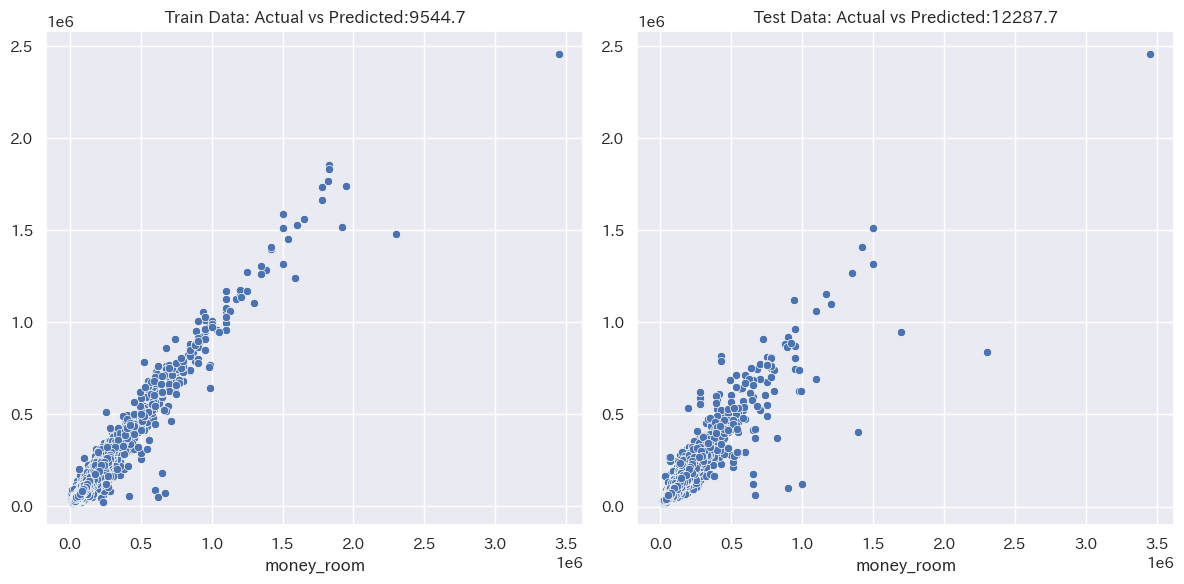

In [38]:
"""
💡trainデータの予測精度が異常に良い場合はオーバーフィッティングの可能性がある💡
"""
# 2つの散布図を横並びに表示するために、matplotlib の subplots を使う
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1行2列のサブプロット

# サブプロット1: トレーニングデータの散布図
sns.scatterplot(x=df_y_train, y=y_pred_train, ax=axes[0])
axes[0].set_title(f'Train Data: Actual vs Predicted:{round(rmse_train,1)}')  # タイトルを追加
# サブプロット1: テストデータの散布図
sns.scatterplot(x=df_y_test, y=y_pred, ax=axes[1])
axes[1].set_title(f'Test Data: Actual vs Predicted:{round(rmse,1)}')  # タイトルを追加

# レイアウト調整
plt.tight_layout()

# 画像として保存
plt.savefig(predict_result_plot_file, format="jpg", dpi=300)

# プロットを表示
plt.show()


In [39]:
#notebook内でJavascriptを動かすためのおまじない
shap.initjs()
#TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
X_test_shap = df_x_test.copy().reset_index(drop=True)
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X_test_shap)
#base_shap_valueに対して、各変数のshapスコア×変数の値を掛け合わせた値が予測値になる。
print("base_shap_value",explainer.expected_value)


base_shap_value 62501.6794445312


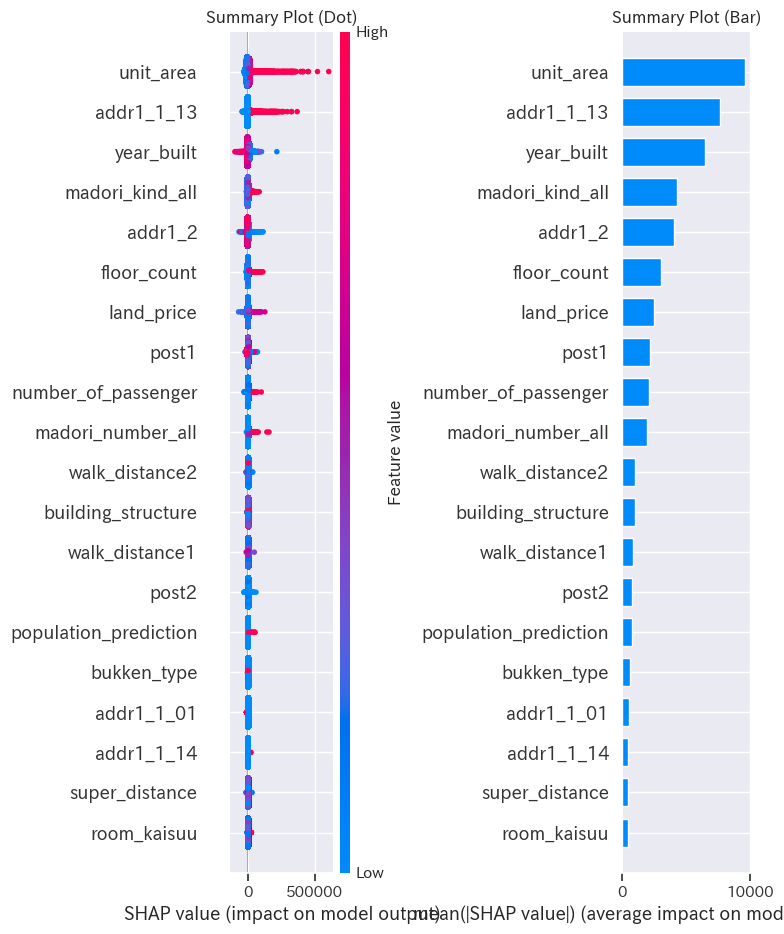

In [40]:
# サブプロットの作成（正方形に設定）
fig, axes = plt.subplots(1, 2, figsize=(10, 10))  # 1行2列のサブプロット、正方形

# 左側の図: summary_plot
plt.sca(axes[0])  # 左側のサブプロットをアクティブに
shap.summary_plot(shap_values, X_test_shap, plot_type='dot', show=False)
axes[0].set_title("Summary Plot (Dot)", fontsize=12)

# 右側の図: bar plot
plt.sca(axes[1])  # 右側のサブプロットをアクティブに
shap.summary_plot(shap_values, X_test_shap, plot_type='bar', show=False)
axes[1].set_title("Summary Plot (Bar)", fontsize=12)

# レイアウト調整
plt.tight_layout()

# 画像として保存
plt.savefig(shap_plot_file, format="jpg", dpi=300)

# プロットを表示
plt.show()


#### 5.create submit.csv

In [41]:
#submit

# 評価用データで賃料を予測
df_test_model_x = df_test
df_test_model_x = pd.get_dummies(df_test_model_x, dtype='int')

y_pred = model.predict(df_test_model_x)

# y_predからデータフレームを作成
pred_df = pd.DataFrame(y_pred, columns=['money_room'])

# pred_dfをCSV出力、ヘッダーなし
pred_df.to_csv(submit_file, index=True, header=False)

# 予測値を確認
display(pred_df.head())

,money_room
0,65170.47
1,52407.80
2,59632.42
3,48008.42
4,48008.42
